# Data Preprocessing for CAR

For: Pao Pao and Suhut Mickey Lin

This file takes in non-text data files in the data folder and aggregate it into train and test files for the *model_*.ipynb* files. This is the most time sensitive. I'll make sure this is done before Wednesday 23rd Apr 2025 (I know that this is extremely late sorry). For now the code below generates a test file for yall to test out the code for the models. The performance will probably be bad but as long as the code runs that is good enough.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from companies import large_banks, medium_banks, small_banks

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
# Start with CAR data

df_car = pd.read_excel("data/Car_Data.xlsx", sheet_name="Bank")

df_car['evtdate'] = pd.to_datetime(df_car['evtdate'])
df_car['datacqtr'] = df_car['evtdate'].dt.to_period('Q').astype('period[Q-DEC]')
df_car['tic'] = df_car['ticker'] 

evtdate = pd.to_datetime(df_car['evtdate']).dt.date.unique().tolist()

df_car = df_car[["datacqtr", "tic", "car5"]]

In [5]:
len(df_car)  # we do not wantto lose any rows

10476

In [6]:
# Get the first and last quarter of the data
first_quarter = df_car['datacqtr'].min()
last_quarter = df_car['datacqtr'].max()
print(f"First quarter: {first_quarter}, Last quarter: {last_quarter}")

First quarter: 1990Q1, Last quarter: 2024Q4


In [7]:
# drop duplicates from df_car by datacqtr and tic
df_car = df_car.drop_duplicates(subset=["datacqtr", "tic"])
# Check length
print(len(df_car))  # we do not want to lose any rows

10385


## ECON SECTION

In [8]:
# Now we calculate the econ data
econ_path = "data/econ_data"

### Feature 1: GDP

In [9]:
df_gdp = pd.read_csv(f"{econ_path}/GDP.csv")  # https://fred.stlouisfed.org/series/GDP (QUARTERLY)
df_gdp = df_gdp.rename(columns={"GDP":"GDP (BILLIONS OF DOLLARS)"})
df_gdp["GDP CHANGE (-1 to 1)"] = df_gdp["GDP (BILLIONS OF DOLLARS)"].pct_change()
df_gdp['observation_date'] = pd.to_datetime(df_gdp['observation_date'])
df_gdp['datacqtr'] = df_gdp['observation_date'].dt.to_period('Q')
df_gdp = df_gdp[["datacqtr", "GDP CHANGE (-1 to 1)"]]

In [10]:
# Find the first and last quarter year
first_quarter = df_gdp['datacqtr'].min()
last_quarter = df_gdp['datacqtr'].max()
print(f"First quarter: {first_quarter}, Last quarter: {last_quarter}")

First quarter: 1947Q1, Last quarter: 2024Q4


In [11]:
# left join the GDP data with the CAR data
df_car = df_car.merge(df_gdp, on=["datacqtr"], how="left")
# Check length
print(len(df_car))  # we do not want to lose any rows
# Count the number of NaN values
print(f"Number of NaN values in GDP data: {df_car['GDP CHANGE (-1 to 1)'].isna().sum()}")

10385
Number of NaN values in GDP data: 0


In [12]:
df_car.head()

,datacqtr,tic,car5,GDP CHANGE (-1 to 1)
0,2019Q2,TCF,0.016011,0.013563
1,2018Q1,TCF,-0.022522,0.014546
2,2018Q4,TCF,0.014032,0.005728
3,2018Q2,TCF,0.041037,0.012414
4,2018Q3,TCF,-0.033751,0.010583


### Feature 2: Unemployment rate

In [13]:
df_unrate = pd.read_csv(f"{econ_path}/UNRATE.csv")  # https://fred.stlouisfed.org/series/UNRATE (MONTHLY)
df_unrate = df_unrate.rename(columns={"UNRATE":"UNEMPLOYMENT RATE (0 to 1)"})
df_unrate["UNEMPLOYMENT RATE (0 to 1)"] = df_unrate["UNEMPLOYMENT RATE (0 to 1)"] / 100
df_unrate['observation_date'] = pd.to_datetime(df_unrate['observation_date'])
df_unrate['datacqtr'] = df_unrate['observation_date'].dt.to_period('Q')
df_unrate = df_unrate.groupby('datacqtr')['UNEMPLOYMENT RATE (0 to 1)'].mean().reset_index()
df_unrate = df_unrate[["datacqtr", "UNEMPLOYMENT RATE (0 to 1)"]]

In [14]:
# left join the unrate data with the CAR data
df_car = df_car.merge(df_unrate, on=["datacqtr"], how="left")
# Check length
print(len(df_car))  # we do not want to lose any rows
# Count the number of NaN values
print(f"Number of NaN values in Unemployment data: {df_car['UNEMPLOYMENT RATE (0 to 1)'].isna().sum()}")

10385
Number of NaN values in Unemployment data: 0


In [15]:
df_car.head()

,datacqtr,tic,car5,GDP CHANGE (-1 to 1),UNEMPLOYMENT RATE (0 to 1)
0,2019Q2,TCF,0.016011,0.013563,0.036333
1,2018Q1,TCF,-0.022522,0.014546,0.040333
2,2018Q4,TCF,0.014032,0.005728,0.038333
3,2018Q2,TCF,0.041037,0.012414,0.039333
4,2018Q3,TCF,-0.033751,0.010583,0.037667


### Feature 3: Prime Loan Rate

In [16]:
df_dprime = pd.read_csv(f"{econ_path}/DPRIME.csv")  # https://fred.stlouisfed.org/series/DPRIME (DAILY)
df_dprime = df_dprime.rename(columns={"DPRIME": "PRIME LOAN RATE (0 to 1)"})
df_dprime["PRIME LOAN RATE (0 to 1)"] = df_dprime["PRIME LOAN RATE (0 to 1)"] / 100
df_dprime['observation_date'] = pd.to_datetime(df_dprime['observation_date'])
df_dprime['datacqtr'] = df_dprime['observation_date'].dt.to_period('Q')
df_dprime = df_dprime.groupby('datacqtr')['PRIME LOAN RATE (0 to 1)'].mean().reset_index()
df_dprime = df_dprime[["datacqtr", "PRIME LOAN RATE (0 to 1)"]]

In [17]:
# left join the dprime data with the CAR data
df_car = df_car.merge(df_dprime, on=["datacqtr"], how="left")
# Check length
print(len(df_car))  # we do not want to lose any rows
# Count the number of NaN values
print(f"Number of NaN values in Prime Loan Rate data: {df_car['PRIME LOAN RATE (0 to 1)'].isna().sum()}")

10385
Number of NaN values in Prime Loan Rate data: 0


In [18]:
df_car.head()

,datacqtr,tic,car5,GDP CHANGE (-1 to 1),UNEMPLOYMENT RATE (0 to 1),PRIME LOAN RATE (0 to 1)
0,2019Q2,TCF,0.016011,0.013563,0.036333,0.055000
1,2018Q1,TCF,-0.022522,0.014546,0.040333,0.045282
2,2018Q4,TCF,0.014032,0.005728,0.038333,0.052782
3,2018Q2,TCF,0.041037,0.012414,0.039333,0.047969
4,2018Q3,TCF,-0.033751,0.010583,0.037667,0.050079


### Feature 4: Deposits

In [19]:
df_deposit = pd.read_csv(f"{econ_path}/DEPOSITS.csv")  # https://fred.stlouisfed.org/series/DPSACBW027SBOG (WEEKLY)
df_deposit = df_deposit.rename(columns={"DPSACBW027SBOG":"DEPOSITS (BILLIONS OF DOLLARS)"})
df_deposit['observation_date'] = pd.to_datetime(df_deposit['observation_date'])
df_deposit['datacqtr'] = df_deposit['observation_date'].dt.to_period('Q')
df_deposit = df_deposit.groupby('datacqtr')['DEPOSITS (BILLIONS OF DOLLARS)'].mean().reset_index()
df_deposit["DEPOSITS CHANGE (-1 to 1)"] = df_deposit["DEPOSITS (BILLIONS OF DOLLARS)"].pct_change()
df_deposit = df_deposit[["datacqtr", "DEPOSITS CHANGE (-1 to 1)"]]

In [20]:
# Join the deposits data with the CAR data
df_car = df_car.merge(df_deposit, on=["datacqtr"], how="left")
# Check length
print(len(df_car))  # we do not want to lose any rows
# Count the number of NaN values
print(f"Number of NaN values in Deposits data: {df_car['DEPOSITS CHANGE (-1 to 1)'].isna().sum()}")

10385
Number of NaN values in Deposits data: 0


In [21]:
df_car.head()

,datacqtr,tic,car5,GDP CHANGE (-1 to 1),UNEMPLOYMENT RATE (0 to 1),PRIME LOAN RATE (0 to 1),DEPOSITS CHANGE (-1 to 1)
0,2019Q2,TCF,0.016011,0.013563,0.036333,0.055000,0.014270
1,2018Q1,TCF,-0.022522,0.014546,0.040333,0.045282,0.003704
2,2018Q4,TCF,0.014032,0.005728,0.038333,0.052782,0.007224
3,2018Q2,TCF,0.041037,0.012414,0.039333,0.047969,0.010578
4,2018Q3,TCF,-0.033751,0.010583,0.037667,0.050079,0.009355


### Feature 5: Consumer Price Index (inflation)

In [22]:
df_inflation = pd.read_csv(f"{econ_path}/INFLATION.csv")  # https://fred.stlouisfed.org/series/CORESTICKM159SFRBATL (MONTHLY)
df_inflation = df_inflation.rename(columns={"CORESTICKM159SFRBATL":"CONSUMER PRICE INDEX (0 to 1)"})
df_inflation["CONSUMER PRICE INDEX (0 to 1)"] = df_inflation["CONSUMER PRICE INDEX (0 to 1)"] / 100
df_inflation['observation_date'] = pd.to_datetime(df_inflation['observation_date'])
df_inflation['datacqtr'] = df_inflation['observation_date'].dt.to_period('Q')
df_inflation = df_inflation.groupby('datacqtr')['CONSUMER PRICE INDEX (0 to 1)'].mean().reset_index()
df_inflation = df_inflation[["datacqtr", "CONSUMER PRICE INDEX (0 to 1)"]]


In [23]:
# Left join the inflation data with the CAR data
df_car = df_car.merge(df_inflation, on=["datacqtr"], how="left")
# Check length
print(len(df_car))  # we do not want to lose any rows
# Count the number of NaN values
print(f"Number of NaN values in Inflation data: {df_car['CONSUMER PRICE INDEX (0 to 1)'].isna().sum()}")

10385
Number of NaN values in Inflation data: 0


In [24]:
df_car.head()

,datacqtr,tic,car5,GDP CHANGE (-1 to 1),UNEMPLOYMENT RATE (0 to 1),PRIME LOAN RATE (0 to 1),DEPOSITS CHANGE (-1 to 1),CONSUMER PRICE INDEX (0 to 1)
0,2019Q2,TCF,0.016011,0.013563,0.036333,0.055000,0.014270,0.023821
1,2018Q1,TCF,-0.022522,0.014546,0.040333,0.045282,0.003704,0.022159
2,2018Q4,TCF,0.014032,0.005728,0.038333,0.052782,0.007224,0.024493
3,2018Q2,TCF,0.041037,0.012414,0.039333,0.047969,0.010578,0.025289
4,2018Q3,TCF,-0.033751,0.010583,0.037667,0.050079,0.009355,0.024714


### Feature 6: Savings

In [25]:
df_savings = pd.read_csv(f"{econ_path}/SAVINGS.csv")  # https://fred.stlouisfed.org/series/W207RC1Q156SBEA (Quarterly)
df_savings = df_savings.rename(columns={"W207RC1Q156SBEA":"SAVINGS PER GROSS INCOME (-1 to 1)"})
df_savings["SAVINGS PER GROSS INCOME (-1 to 1)"] = df_savings["SAVINGS PER GROSS INCOME (-1 to 1)"] / 100
df_savings['observation_date'] = pd.to_datetime(df_savings['observation_date'])
df_savings['datacqtr'] = df_savings['observation_date'].dt.to_period('Q')
df_savings = df_savings[["datacqtr", "SAVINGS PER GROSS INCOME (-1 to 1)"]]

In [26]:
# Join the savings data with the CAR data
df_car = df_car.merge(df_savings, on=["datacqtr"], how="left")
# Check length
print(len(df_car))  # we do not want to lose any rows
# Count the number of NaN values
print(f"Number of NaN values in Savings data: {df_car['SAVINGS PER GROSS INCOME (-1 to 1)'].isna().sum()}")

10385
Number of NaN values in Savings data: 0


In [27]:
df_car.head()

,datacqtr,tic,car5,GDP CHANGE (-1 to 1),UNEMPLOYMENT RATE (0 to 1),PRIME LOAN RATE (0 to 1),DEPOSITS CHANGE (-1 to 1),CONSUMER PRICE INDEX (0 to 1),SAVINGS PER GROSS INCOME (-1 to 1)
0,2019Q2,TCF,0.016011,0.013563,0.036333,0.055000,0.014270,0.023821,0.032
1,2018Q1,TCF,-0.022522,0.014546,0.040333,0.045282,0.003704,0.022159,0.029
2,2018Q4,TCF,0.014032,0.005728,0.038333,0.052782,0.007224,0.024493,0.032
3,2018Q2,TCF,0.041037,0.012414,0.039333,0.047969,0.010578,0.025289,0.029
4,2018Q3,TCF,-0.033751,0.010583,0.037667,0.050079,0.009355,0.024714,0.032


## Fundamentals Section

In [28]:
from utililties import interpolate_missing_values, fill_with_industry_average, get_bank_peers, check_if_all_nan_by_ticker

In [29]:
fundamentals_path = "data/fundamentals"

df_fundamentals = pd.read_csv(f"{fundamentals_path}/fundamentals_banking.csv")
df_fundamentals["cik"] = df_fundamentals["cik"].astype(str)
df_fundamentals["datacqtr"] = pd.to_datetime(df_fundamentals["datacqtr"])
df_fundamentals['datacqtr'] = df_fundamentals['datacqtr'].dt.to_period('Q')

In [30]:
interested_cols = ["niitq", "nimq", "ncoq", "cheq", "niq"]  # finrevq
name_map = {"niitq": "Net Interest Income", "nimq": "Net Interest Margin", "ncoq": "Net Charge-Offs", "cheq": "Cash and Short-Term Investments", "niq": "Net Income"}
key_cols = ["datacqtr", "datadate", "rdq", "tic", "cik",]

# Check if any columns cant be found
for col in interested_cols:
    if col not in df_fundamentals.columns:
        print(col)

In [31]:
df_fundamentals_simplified = df_fundamentals[key_cols + interested_cols]
df_fundamentals_simplified = df_fundamentals_simplified.rename(columns=name_map)

# Check if any columns are all NaN
nan_columns = df_fundamentals_simplified.columns[df_fundamentals_simplified.isna().all()].tolist()
print("Columns with only NaN values:", nan_columns)

Columns with only NaN values: []


In [32]:
df_fundamentals_simplified.head()

,datacqtr,datadate,rdq,tic,cik,Net Interest Income,Net Interest Margin,Net Charge-Offs,Cash and Short-Term Investments,Net Income
0,2000Q1,31/03/2000,19/04/2000,JPM,19617.0,2438.0,2.59,-587.0,47719.0,1988.0
1,2000Q2,30/06/2000,19/07/2000,JPM,19617.0,2317.0,2.48,-577.0,49740.0,1633.0
2,2000Q3,30/09/2000,18/10/2000,JPM,19617.0,2362.0,2.47,-559.0,50091.0,1398.0
3,2000Q4,31/12/2000,17/01/2001,JPM,19617.0,2479.0,1.82,323.0,101779.0,708.0
4,2001Q1,31/03/2001,18/04/2001,JPM,19617.0,2436.0,1.80,-688.0,101497.0,1199.0


In [33]:
# Get the first and last quarter of the fundamentals data

first_quarter = df_fundamentals_simplified['datacqtr'].min()
last_quarter = df_fundamentals_simplified['datacqtr'].max()
print(f"First quarter: {first_quarter}, Last quarter: {last_quarter}")

# count number of quarters
print(f"Number of quarters in the data: {len(df_fundamentals_simplified['datacqtr'].unique())}")

First quarter: 2000Q1, Last quarter: 2024Q4
Number of quarters in the data: 101


In [34]:
# Number of tickers
print(f"Number of tickers in the data: {len(df_fundamentals_simplified['tic'].unique())}")

Number of tickers in the data: 150


In [35]:
# Filter CAR data to match the range of the fundamentals data
df_car = df_car[(df_car['datacqtr'] >= first_quarter) & (df_car['datacqtr'] <= last_quarter)]
# Check length
print(len(df_car))

9502


### Feature 7: Net Interest Income

In [36]:
df_net_interest_income = df_fundamentals_simplified[["datacqtr", "tic", "Net Interest Income"]]

In [37]:
# Drop rows with datacqtr as NaN
df_net_interest_income = df_net_interest_income.dropna(subset=["datacqtr"])
# Check length
print(len(df_net_interest_income))  # we do not want to lose any rows

11503


In [38]:
# For each ticker, add rows from the CAR data to match tic and datacqtr
df_net_interest_income = df_net_interest_income.merge(df_car[["datacqtr", "tic"]], on=["datacqtr", "tic"], how="outer")

In [39]:
# Count the number of NaN values in each column
print("Number of NaN values in Net Interest Income data:\n", df_net_interest_income.isna().sum())
# Number of rows
print("Number of rows in Net Interest Income data:", len(df_net_interest_income))

Number of NaN values in Net Interest Income data:
 datacqtr                  0
tic                       0
Net Interest Income    3266
dtype: int64
Number of rows in Net Interest Income data: 11669


Around 30\% missing.

In [40]:
# Figure out Are the missing values randomly distributed or concentrated in specific periods/banks
df_missing = df_net_interest_income[df_net_interest_income["Net Interest Income"].isna()]
# Count number group by datacqtr
print("Missing values grouped by datacqtr:\n", df_missing.groupby("datacqtr").size().sort_values(ascending=False))
# Count number group by tic
print("Missing values grouped by tic:\n", df_missing.groupby("tic").size().sort_values(ascending=False))

Missing values grouped by datacqtr:
 datacqtr
2001Q3    54
2001Q2    53
2001Q1    52
2000Q1    48
2000Q2    48
          ..
2019Q4    20
2020Q4    20
2023Q3    20
2023Q4    20
2024Q3    19
Freq: Q-DEC, Length: 100, dtype: int64
Missing values grouped by tic:
 tic
NEWT    100
HBNC    100
EVBN    100
C       100
COF     100
       ... 
TBBK      1
ASRV      1
SUSQ      1
SMMF      1
OPHC      1
Length: 120, dtype: int64


In [41]:
empty_tickers = check_if_all_nan_by_ticker(df_net_interest_income, 'Net Interest Income')
for ticker in empty_tickers:
    df_net_interest_income = fill_with_industry_average(df_net_interest_income, ticker, get_bank_peers(ticker), 'Net Interest Income')
len(df_net_interest_income)

11669

In [42]:
# Count the number of NaN values in each column
print("Number of NaN values in Net Interest Income data:\n", df_net_interest_income.isna().sum())
# Number of rows
print("Number of rows in Net Interest Income data:", len(df_net_interest_income))

Number of NaN values in Net Interest Income data:
 datacqtr                  0
tic                       0
Net Interest Income    1972
dtype: int64
Number of rows in Net Interest Income data: 11669


In [43]:
df_net_interest_income = interpolate_missing_values(df_net_interest_income, 'Net Interest Income')

In [44]:
# Count the number of NaN values in each column
print("Number of NaN values in Net Interest Income data:\n", df_net_interest_income.isna().sum())
# Number of rows
print("Number of rows in Net Interest Income data:", len(df_net_interest_income))

Number of NaN values in Net Interest Income data:
 datacqtr               0
tic                    0
Net Interest Income    0
dtype: int64
Number of rows in Net Interest Income data: 11669


In [45]:
# Join net interest income data with the CAR data
df_car = df_car.merge(df_net_interest_income, on=["datacqtr", "tic"], how="left")
# Check length
print(len(df_car))  # we do not want to lose any rows
# Count the number of NaN values
print(f"Number of NaN values in CAR data: {df_car.isna().sum().sum()}")

9502
Number of NaN values in CAR data: 0


In [46]:
df_car.head()

,datacqtr,tic,car5,GDP CHANGE (-1 to 1),UNEMPLOYMENT RATE (0 to 1),PRIME LOAN RATE (0 to 1),DEPOSITS CHANGE (-1 to 1),CONSUMER PRICE INDEX (0 to 1),SAVINGS PER GROSS INCOME (-1 to 1),Net Interest Income
0,2019Q2,TCF,0.016011,0.013563,0.036333,0.055000,0.014270,0.023821,0.032,255.394
1,2018Q1,TCF,-0.022522,0.014546,0.040333,0.045282,0.003704,0.022159,0.029,245.255
2,2018Q4,TCF,0.014032,0.005728,0.038333,0.052782,0.007224,0.024493,0.032,255.252
3,2018Q2,TCF,0.041037,0.012414,0.039333,0.047969,0.010578,0.025289,0.029,260.741
4,2018Q3,TCF,-0.033751,0.010583,0.037667,0.050079,0.009355,0.024714,0.032,255.616


### Feature 8: Net Interest Margin

In [47]:
df_net_interest_margin = df_fundamentals_simplified[["datacqtr", "tic", "Net Interest Margin"]]

In [48]:
# Drop rows with datacqtr as NaN
df_net_interest_margin = df_net_interest_margin.dropna(subset=["datacqtr"])
# Check length
print(len(df_net_interest_margin))  # we do not want to lose any rows

11503


In [49]:
# For each ticker, add rows from the CAR data to match tic and datacqtr
df_net_interest_margin = df_net_interest_margin.merge(df_car[["datacqtr", "tic"]], on=["datacqtr", "tic"], how="outer")

In [50]:
# Count the number of NaN values in each column
print("Number of NaN values in Net Interest Income data:\n", df_net_interest_margin.isna().sum())
# Number of rows
print("Number of rows in Net Interest Income data:", len(df_net_interest_margin))

Number of NaN values in Net Interest Income data:
 datacqtr                  0
tic                       0
Net Interest Margin    1118
dtype: int64
Number of rows in Net Interest Income data: 11669


In [51]:
# Figure out Are the missing values randomly distributed or concentrated in specific periods/banks
df_missing = df_net_interest_margin[df_net_interest_margin["Net Interest Margin"].isna()]
# Count number group by datacqtr
print("Missing values grouped by datacqtr:\n", df_missing.groupby("datacqtr").size().sort_values(ascending=False))
# Count number group by tic
print("Missing values grouped by tic:\n", df_missing.groupby("tic").size().sort_values(ascending=False))

Missing values grouped by datacqtr:
 datacqtr
2001Q1    23
2000Q1    20
2002Q1    20
2002Q2    19
2000Q2    18
          ..
2008Q3     6
2008Q1     6
2007Q4     6
2007Q3     6
2008Q2     5
Freq: Q-DEC, Length: 100, dtype: int64
Missing values grouped by tic:
 tic
NEWT    100
COF     100
C       100
SRL      98
PACW     88
       ... 
FSGI      1
ALNC      1
HOPE      1
IBCA      1
XBKS      1
Length: 92, dtype: int64


In [52]:
empty_tickers = check_if_all_nan_by_ticker(df_net_interest_margin, 'Net Interest Margin')
for ticker in empty_tickers:
    df_net_interest_margin = fill_with_industry_average(df_net_interest_margin, ticker, get_bank_peers(ticker), 'Net Interest Margin')
len(df_net_interest_margin)

11669

In [53]:
df_net_interest_margin = interpolate_missing_values(df_net_interest_margin, 'Net Interest Margin')

In [54]:
# Count the number of NaN values in each column
print("Number of NaN values in Net Interest Margin data:\n", df_net_interest_margin.isna().sum())
# Number of rows
print("Number of rows in Net Interest Margin data:", len(df_net_interest_margin))

Number of NaN values in Net Interest Margin data:
 datacqtr               0
tic                    0
Net Interest Margin    0
dtype: int64
Number of rows in Net Interest Margin data: 11669


In [55]:
# Join net interest margin data with the CAR data
df_car = df_car.merge(df_net_interest_margin, on=["datacqtr", "tic"], how="left")
# Check length
print(len(df_car))  # we do not want to lose any rows
# Count the number of NaN values
print(f"Number of NaN values in CAR data: {df_car.isna().sum().sum()}")

9502
Number of NaN values in CAR data: 0


In [56]:
df_car.head()

,datacqtr,tic,car5,GDP CHANGE (-1 to 1),UNEMPLOYMENT RATE (0 to 1),PRIME LOAN RATE (0 to 1),DEPOSITS CHANGE (-1 to 1),CONSUMER PRICE INDEX (0 to 1),SAVINGS PER GROSS INCOME (-1 to 1),Net Interest Income,Net Interest Margin
0,2019Q2,TCF,0.016011,0.013563,0.036333,0.055000,0.014270,0.023821,0.032,255.394,4.43
1,2018Q1,TCF,-0.022522,0.014546,0.040333,0.045282,0.003704,0.022159,0.029,245.255,4.59
2,2018Q4,TCF,0.014032,0.005728,0.038333,0.052782,0.007224,0.024493,0.032,255.252,4.60
3,2018Q2,TCF,0.041037,0.012414,0.039333,0.047969,0.010578,0.025289,0.029,260.741,4.67
4,2018Q3,TCF,-0.033751,0.010583,0.037667,0.050079,0.009355,0.024714,0.032,255.616,4.66


### Feature 9: Net Charge-Offs

In [57]:
feature = "Net Charge-Offs"
df_feature = df_fundamentals_simplified[["datacqtr", "tic", feature]]
# Drop rows with datacqtr as NaN
df_feature = df_feature.dropna(subset=["datacqtr"])
df_feature = df_feature.merge(df_car[["datacqtr", "tic"]], on=["datacqtr", "tic"], how="outer")

# Count the number of NaN values in each column
print(f"Number of NaN values in {feature} data:\n", df_feature.isna().sum())
# Number of rows
print(f"Number of rows in {feature} data:", len(df_feature))

Number of NaN values in Net Charge-Offs data:
 datacqtr              0
tic                   0
Net Charge-Offs    1097
dtype: int64
Number of rows in Net Charge-Offs data: 11669


In [58]:
empty_tickers = check_if_all_nan_by_ticker(df_feature, feature)
for ticker in empty_tickers:
    df_feature = fill_with_industry_average(df_feature, ticker, get_bank_peers(ticker), feature)
len(df_feature)

11669

In [59]:
df_feature = interpolate_missing_values(df_feature, feature)

In [60]:
# Count the number of NaN values in each column
print(f"Number of NaN values in {feature} data:\n", df_feature.isna().sum())
# Number of rows
print(f"Number of rows in {feature} data:", len(df_feature))

Number of NaN values in Net Charge-Offs data:
 datacqtr           0
tic                0
Net Charge-Offs    0
dtype: int64
Number of rows in Net Charge-Offs data: 11669


In [61]:
# Join net interest margin data with the CAR data
df_car = df_car.merge(df_feature, on=["datacqtr", "tic"], how="left")
# Check length
print(len(df_car))  # we do not want to lose any rows
# Count the number of NaN values
print(f"Number of NaN values in CAR data: {df_car.isna().sum().sum()}")

9502
Number of NaN values in CAR data: 0


### Feature 10: Cash and Short-Term Investments

In [62]:
feature = "Cash and Short-Term Investments"
df_feature = df_fundamentals_simplified[["datacqtr", "tic", feature]]
# Drop rows with datacqtr as NaN
df_feature = df_feature.dropna(subset=["datacqtr"])
df_feature = df_feature.merge(df_car[["datacqtr", "tic"]], on=["datacqtr", "tic"], how="outer")

# Count the number of NaN values in each column
print(f"Number of NaN values in {feature} data:\n", df_feature.isna().sum())
# Number of rows
print(f"Number of rows in {feature} data:", len(df_feature))

Number of NaN values in Cash and Short-Term Investments data:
 datacqtr                             0
tic                                  0
Cash and Short-Term Investments    413
dtype: int64
Number of rows in Cash and Short-Term Investments data: 11669


In [63]:
empty_tickers = check_if_all_nan_by_ticker(df_feature, feature)
for ticker in empty_tickers:
    df_feature = fill_with_industry_average(df_feature, ticker, get_bank_peers(ticker), feature)
len(df_feature)

11669

In [64]:
df_feature = interpolate_missing_values(df_feature, feature)

In [65]:
# Count the number of NaN values in each column
print(f"Number of NaN values in {feature} data:\n", df_feature.isna().sum())
# Number of rows
print(f"Number of rows in {feature} data:", len(df_feature))

Number of NaN values in Cash and Short-Term Investments data:
 datacqtr                           0
tic                                0
Cash and Short-Term Investments    0
dtype: int64
Number of rows in Cash and Short-Term Investments data: 11669


In [66]:
# Join net interest margin data with the CAR data
df_car = df_car.merge(df_feature, on=["datacqtr", "tic"], how="left")
# Check length
print(len(df_car))  # we do not want to lose any rows
# Count the number of NaN values
print(f"Number of NaN values in CAR data: {df_car.isna().sum().sum()}")

9502
Number of NaN values in CAR data: 0


### Feature 11: Net Income

In [67]:
feature = "Net Income"
df_feature = df_fundamentals_simplified[["datacqtr", "tic", feature]]
# Drop rows with datacqtr as NaN
df_feature = df_feature.dropna(subset=["datacqtr"])
df_feature = df_feature.merge(df_car[["datacqtr", "tic"]], on=["datacqtr", "tic"], how="outer")

# Count the number of NaN values in each column
print(f"Number of NaN values in {feature} data:\n", df_feature.isna().sum())
# Number of rows
print(f"Number of rows in {feature} data:", len(df_feature))

Number of NaN values in Net Income data:
 datacqtr        0
tic             0
Net Income    263
dtype: int64
Number of rows in Net Income data: 11669


In [68]:
empty_tickers = check_if_all_nan_by_ticker(df_feature, feature)
for ticker in empty_tickers:
    df_feature = fill_with_industry_average(df_feature, ticker, get_bank_peers(ticker), feature)
len(df_feature)

11669

In [69]:
df_feature = interpolate_missing_values(df_feature, feature)

In [70]:
# Count the number of NaN values in each column
print(f"Number of NaN values in {feature} data:\n", df_feature.isna().sum())
# Number of rows
print(f"Number of rows in {feature} data:", len(df_feature))

Number of NaN values in Net Income data:
 datacqtr      0
tic           0
Net Income    0
dtype: int64
Number of rows in Net Income data: 11669


In [71]:
# Join net interest margin data with the CAR data
df_car = df_car.merge(df_feature, on=["datacqtr", "tic"], how="left")
# Check length
print(len(df_car))  # we do not want to lose any rows
# Count the number of NaN values
print(f"Number of NaN values in CAR data: {df_car.isna().sum().sum()}")

9502
Number of NaN values in CAR data: 0


In [72]:
df_car.head()

,datacqtr,tic,car5,GDP CHANGE (-1 to 1),UNEMPLOYMENT RATE (0 to 1),PRIME LOAN RATE (0 to 1),DEPOSITS CHANGE (-1 to 1),CONSUMER PRICE INDEX (0 to 1),SAVINGS PER GROSS INCOME (-1 to 1),Net Interest Income,Net Interest Margin,Net Charge-Offs,Cash and Short-Term Investments,Net Income
0,2019Q2,TCF,0.016011,0.013563,0.036333,0.055000,0.014270,0.023821,0.032,255.394,4.43,-14.082,555.271,90.427
1,2018Q1,TCF,-0.022522,0.014546,0.040333,0.045282,0.003704,0.022159,0.029,245.255,4.59,-14.151,588.893,73.761
2,2018Q4,TCF,0.014032,0.005728,0.038333,0.052782,0.007224,0.024493,0.032,255.252,4.60,-21.314,587.057,85.652
3,2018Q2,TCF,0.041037,0.012414,0.039333,0.047969,0.010578,0.025289,0.029,260.741,4.67,-12.770,581.876,58.749
4,2018Q3,TCF,-0.033751,0.010583,0.037667,0.050079,0.009355,0.024714,0.032,255.616,4.66,-6.790,569.968,86.196


## Second Fundamentals File

In [73]:
df_bank_fundamentals_drive = pd.read_csv(f"{fundamentals_path}/banking_fundamental_drive.csv")
df_bank_fundamentals_drive["cik"] = df_bank_fundamentals_drive["cik"].astype(str)
df_bank_fundamentals_drive["datacqtr"] = pd.to_datetime(df_bank_fundamentals_drive["datacqtr"])
df_bank_fundamentals_drive['datacqtr'] = df_bank_fundamentals_drive['datacqtr'].dt.to_period('Q')

In [74]:
interested_cols_2 = ["dibq", "dpscq", "dptcq", "icaptq", "iditq"]
name_map_2 = {"dibq": "Deposits - Interest Bearing", "dpscq": "Total Savings Deposits", "dptcq": "Deposits - Total", "icaptq": "Invested Capital - Total", "iditq": "Interest Income - Total"}

# Deposits - Interest Bearing (dibq)
# Total Savings Deposits (dpscq)
# Deposits - Total (dptcq)
# Invested Capital - Total (icaptq)
# Interest Income - Total (iditq)
# Total Domestic Deposits (tdomdq)
# Total Foreign Deposits (tfdq)

# Total Current Operating Revenue ("tcorq")

In [75]:
df_bank_fundamentals_drive_simplified = df_bank_fundamentals_drive[key_cols + interested_cols_2 + ["tcorq"]]
df_bank_fundamentals_drive_simplified = df_bank_fundamentals_drive_simplified.rename(columns=name_map_2)
df_bank_fundamentals_drive_simplified = df_bank_fundamentals_drive_simplified.rename(columns={"tcorq": "Total Current Operating Revenue"})

In [76]:
df_bank_fundamentals_drive_simplified.head()

,datacqtr,datadate,rdq,tic,cik,Deposits - Interest Bearing,Total Savings Deposits,Deposits - Total,Invested Capital - Total,Interest Income - Total,Total Current Operating Revenue
0,2001Q1,03/31/2001,04/17/2001,ASO.1,3133.0,21574.519,11126.745,26224.351,9101.782,699.817,882.118
1,2001Q2,06/30/2001,07/17/2001,ASO.1,3133.0,21246.878,11032.448,25984.901,9102.459,678.581,866.228
2,2001Q3,09/30/2001,10/16/2001,ASO.1,3133.0,21158.285,11382.585,25873.948,9127.017,648.369,840.719
3,2001Q4,12/31/2001,01/15/2002,ASO.1,3133.0,20886.396,11748.793,26167.017,9121.355,607.773,793.697
4,2002Q1,03/31/2002,04/16/2002,ASO.1,3133.0,20822.393,11931.066,25672.792,9143.441,570.556,748.219


In [77]:
len(df_bank_fundamentals_drive_simplified)

69586

In [78]:
# Get the first and last quarter of the fundamentals data

first_quarter = df_bank_fundamentals_drive_simplified['datacqtr'].min()
last_quarter = df_bank_fundamentals_drive_simplified['datacqtr'].max()
print(f"First quarter: {first_quarter}, Last quarter: {last_quarter}")

# count number of quarters
print(f"Number of quarters in the data: {len(df_bank_fundamentals_drive_simplified['datacqtr'].unique())}")

First quarter: 2000Q4, Last quarter: 2024Q4
Number of quarters in the data: 98


### Feature 12: Deposits - Interest Bearing

In [79]:
feature = "Deposits - Interest Bearing"
df_feature = df_bank_fundamentals_drive_simplified[["datacqtr", "tic", feature]]
# Drop rows with datacqtr as NaN
df_feature = df_feature.dropna(subset=["datacqtr"])
df_feature = df_feature.dropna(subset=["tic"])
df_feature = df_feature.merge(df_car[["datacqtr", "tic"]], on=["datacqtr", "tic"], how="outer")

# Count the number of NaN values in each column
print(f"Number of NaN values in {feature} data:\n", df_feature.isna().sum())
# Number of rows
print(f"Number of rows in {feature} data:", len(df_feature))

Number of NaN values in Deposits - Interest Bearing data:
 datacqtr                           0
tic                                0
Deposits - Interest Bearing    65279
dtype: int64
Number of rows in Deposits - Interest Bearing data: 70296


**Too many missing values!**

### Feature 13: Total Savings Deposits

In [80]:
feature = "Total Savings Deposits"
df_feature = df_bank_fundamentals_drive_simplified[["datacqtr", "tic", feature]]
# Drop rows with datacqtr as NaN
df_feature = df_feature.dropna(subset=["datacqtr"])
df_feature = df_feature.dropna(subset=["tic"])
df_feature = df_feature.merge(df_car[["datacqtr", "tic"]], on=["datacqtr", "tic"], how="outer")

# Count the number of NaN values in each column
print(f"Number of NaN values in {feature} data:\n", df_feature.isna().sum())
# Number of rows
print(f"Number of rows in {feature} data:", len(df_feature))

Number of NaN values in Total Savings Deposits data:
 datacqtr                      0
tic                           0
Total Savings Deposits    66658
dtype: int64
Number of rows in Total Savings Deposits data: 70296


**Too many missing values!**

### Feature 14: Invested Capital - Total

In [81]:
feature = "Invested Capital - Total"
df_feature = df_bank_fundamentals_drive_simplified[["datacqtr", "tic", feature]]
# Drop rows with datacqtr as NaN
df_feature = df_feature.dropna(subset=["datacqtr"])
df_feature = df_feature.dropna(subset=["tic"])
df_feature = df_feature.merge(df_car[["datacqtr", "tic"]], on=["datacqtr", "tic"], how="outer")

# Count the number of NaN values in each column
print(f"Number of NaN values in {feature} data:\n", df_feature.isna().sum())
# Number of rows
print(f"Number of rows in {feature} data:", len(df_feature))

Number of NaN values in Invested Capital - Total data:
 datacqtr                       0
tic                            0
Invested Capital - Total    6705
dtype: int64
Number of rows in Invested Capital - Total data: 70296


In [82]:
empty_tickers = check_if_all_nan_by_ticker(df_feature, feature)
for ticker in empty_tickers:
    if (ticker not in large_banks) and (ticker not in medium_banks) and (ticker not in small_banks):
        continue 
    df_feature = fill_with_industry_average(df_feature, ticker, get_bank_peers(ticker), feature)
len(df_feature)

70296

In [83]:
df_feature = interpolate_missing_values(df_feature, feature)

In [84]:
# Count the number of NaN values in each column
print(f"Number of NaN values in {feature} data:\n", df_feature.isna().sum())
# Number of rows
print(f"Number of rows in {feature} data:", len(df_feature))

Number of NaN values in Invested Capital - Total data:
 datacqtr                    0
tic                         0
Invested Capital - Total    0
dtype: int64
Number of rows in Invested Capital - Total data: 70296


In [85]:
# Join net interest margin data with the CAR data
df_car = df_car.merge(df_feature, on=["datacqtr", "tic"], how="left")
# Check length
print(len(df_car))  # we do not want to lose any rows
# Count the number of NaN values
print(f"Number of NaN values in CAR data: {df_car.isna().sum().sum()}")

9502
Number of NaN values in CAR data: 0


### Feature 15: Total Current Operating Revenue

In [86]:
feature = "Total Current Operating Revenue"
df_feature = df_bank_fundamentals_drive_simplified[["datacqtr", "tic", feature]]
# Drop rows with datacqtr as NaN
df_feature = df_feature.dropna(subset=["datacqtr"])
df_feature = df_feature.dropna(subset=["tic"])
df_feature = df_feature.merge(df_car[["datacqtr", "tic"]], on=["datacqtr", "tic"], how="outer")

# Count the number of NaN values in each column
print(f"Number of NaN values in {feature} data:\n", df_feature.isna().sum())
# Number of rows
print(f"Number of rows in {feature} data:", len(df_feature))

Number of NaN values in Total Current Operating Revenue data:
 datacqtr                              0
tic                                   0
Total Current Operating Revenue    5730
dtype: int64
Number of rows in Total Current Operating Revenue data: 70296


In [87]:
df_feature.describe()

,Total Current Operating Revenue
count,64566.000000
mean,698.873329
std,3794.294616
min,-11306.432000
25%,8.061000
50%,18.326500
75%,68.364750
max,98966.417000


In [88]:
empty_tickers = check_if_all_nan_by_ticker(df_feature, feature)
for ticker in empty_tickers:
    if (ticker not in large_banks) and (ticker not in medium_banks) and (ticker not in small_banks):
        continue 
    df_feature = fill_with_industry_average(df_feature, ticker, get_bank_peers(ticker), feature)
len(df_feature)

70296

In [89]:
df_feature = interpolate_missing_values(df_feature, feature)

In [90]:
df_feature.describe()

,Total Current Operating Revenue
count,70296.000000
mean,720.522539
std,3723.382523
min,-11306.432000
25%,8.299750
50%,19.266500
75%,74.169000
max,98966.417000


In [91]:
# Count the number of NaN values in each column
print(f"Number of NaN values in {feature} data:\n", df_feature.isna().sum())
# Number of rows
print(f"Number of rows in {feature} data:", len(df_feature))

Number of NaN values in Total Current Operating Revenue data:
 datacqtr                           0
tic                                0
Total Current Operating Revenue    0
dtype: int64
Number of rows in Total Current Operating Revenue data: 70296


In [92]:
# Join net interest margin data with the CAR data
df_car = df_car.merge(df_feature, on=["datacqtr", "tic"], how="left")
# Check length
print(len(df_car))  # we do not want to lose any rows
# Count the number of NaN values
print(f"Number of NaN values in CAR data: {df_car.isna().sum().sum()}")

9502
Number of NaN values in CAR data: 0


In [93]:
df_car.head()

,datacqtr,tic,car5,GDP CHANGE (-1 to 1),UNEMPLOYMENT RATE (0 to 1),PRIME LOAN RATE (0 to 1),DEPOSITS CHANGE (-1 to 1),CONSUMER PRICE INDEX (0 to 1),SAVINGS PER GROSS INCOME (-1 to 1),Net Interest Income,Net Interest Margin,Net Charge-Offs,Cash and Short-Term Investments,Net Income,Invested Capital - Total,Total Current Operating Revenue
0,2019Q2,TCF,0.016011,0.013563,0.036333,0.055000,0.014270,0.023821,0.032,255.394,4.43,-14.082,555.271,90.427,4429.344,419.433
1,2018Q1,TCF,-0.022522,0.014546,0.040333,0.045282,0.003704,0.022159,0.029,245.255,4.59,-14.151,588.893,73.761,4008.926,387.403
2,2018Q4,TCF,0.014032,0.005728,0.038333,0.052782,0.007224,0.024493,0.032,255.252,4.60,-21.314,587.057,85.652,3964.060,421.610
3,2018Q2,TCF,0.041037,0.012414,0.039333,0.047969,0.010578,0.025289,0.029,260.741,4.67,-12.770,581.876,58.749,4059.147,400.688
4,2018Q3,TCF,-0.033751,0.010583,0.037667,0.050079,0.009355,0.024714,0.032,255.616,4.66,-6.790,569.968,86.196,3699.553,403.677


## Other market data as features

In [94]:
import yfinance as yf
from ta.momentum import RSIIndicator
from ta.trend import SMAIndicator

In [95]:
tickers = df_car['tic'].unique()

In [96]:
# get min and max date
min_date = df_car['datacqtr'].min().to_timestamp()
max_date = df_car['datacqtr'].max().to_timestamp()
print(f"Min date: {min_date}, Max date: {max_date}")

Min date: 2000-01-01 00:00:00, Max date: 2024-10-01 00:00:00


In [97]:
# Adjust mindate to 1 year before the min date
min_date = min_date - pd.DateOffset(years=1)

### S&P500

In [98]:
# Download S&P 500 data
ticker_obj = yf.Ticker("^GSPC")
sp500 = ticker_obj.history(start=min_date, end=max_date)

# Calculate regular SMAs first
# SMA 5
sma5 = SMAIndicator(close=sp500['Close'], window=5, fillna=True)
sp500['S&P_SMA5'] = sma5.sma_indicator()

# SMA 20
sma20 = SMAIndicator(close=sp500['Close'], window=20, fillna=True)
sp500['S&P_SMA20'] = sma20.sma_indicator()

# SMA 50
sma50 = SMAIndicator(close=sp500['Close'], window=50, fillna=True)
sp500['S&P_SMA50'] = sma50.sma_indicator()

# RSI
rsi = RSIIndicator(close=sp500['Close'], window=14, fillna=True)
sp500['S&P_RSI'] = rsi.rsi() / 100

# Now calculate normalized SMAs according to your formula
# For each point, normalize by the oldest value in the window

# Normalized SMA 5
sp500['S&P_SMA5'] = sp500['S&P_SMA5'] / (sp500['Close'].shift(4)) - 1

# Normalized SMA 20
sp500['S&P_SMA20'] = sp500['S&P_SMA20'] / (sp500['Close'].shift(19)) - 1

# Normalized SMA 50
sp500['S&P_SMA50'] = sp500['S&P_SMA50'] / (sp500['Close'].shift(49)) - 1

In [99]:
# Reset index and get dataqtr
sp500 = sp500.reset_index()
sp500['evtdate'] = pd.to_datetime(sp500['Date']).dt.date
# Take only date that is in evtdate
sp500 = sp500[sp500['evtdate'].isin(evtdate)]
sp500 = sp500[['evtdate', 'Close', 'S&P_SMA5', 'S&P_SMA20', 'S&P_SMA50', 'S&P_RSI']]
sp500['evtdate'] = pd.to_datetime(sp500['evtdate'])

df_car_2 = pd.read_excel("data/Car_Data.xlsx", sheet_name="Bank")
df_car_2['evtdate'] = pd.to_datetime(df_car_2['evtdate'])
df_car_2 = df_car_2.merge(sp500, on='evtdate', how='left')
df_car_2['datacqtr'] = df_car_2['evtdate'].dt.to_period('Q').astype('period[Q-DEC]')
df_car_2 = df_car_2.rename(columns={'ticker': 'tic'})

df_car_2 = df_car_2[['datacqtr', 'tic', 'S&P_SMA5', 'S&P_SMA20', 'S&P_SMA50', 'S&P_RSI']]

In [100]:
# drop duplicates from df_car_2 by datacqtr and tic
df_car_2 = df_car_2.drop_duplicates(subset=["datacqtr", "tic"])

In [101]:
# Join CAR data with S&P 500 data
df_car = df_car.merge(df_car_2, on=["datacqtr", "tic"], how="left")
# Check length
print(len(df_car))  # we do not want to lose any rows
# Count the number of NaN values
print(f"Number of NaN values in CAR data: {df_car.isna().sum().sum()}")

9502
Number of NaN values in CAR data: 352


In [102]:
df_cars = []
for ticker in df_car['tic'].unique():
    df_car_temp = df_car[df_car['tic'] == ticker].copy()
    df_car_temp = df_car_temp.sort_values(by='datacqtr')
    df_car_temp = interpolate_missing_values(df_car_temp, 'S&P_SMA5')
    df_car_temp = interpolate_missing_values(df_car_temp, 'S&P_SMA20')
    df_car_temp = interpolate_missing_values(df_car_temp, 'S&P_SMA50')
    df_car_temp = interpolate_missing_values(df_car_temp, 'S&P_RSI')
    df_cars.append(df_car_temp)

df_car = pd.concat(df_cars, ignore_index=True)

In [103]:
# Check length
print(len(df_car))  # we do not want to lose any rows
# Count the number of NaN values
print(f"Number of NaN values in CAR data: {df_car.isna().sum().sum()}")

9502
Number of NaN values in CAR data: 0


In [104]:
df_car.head()

,datacqtr,tic,car5,GDP CHANGE (-1 to 1),UNEMPLOYMENT RATE (0 to 1),PRIME LOAN RATE (0 to 1),DEPOSITS CHANGE (-1 to 1),CONSUMER PRICE INDEX (0 to 1),SAVINGS PER GROSS INCOME (-1 to 1),Net Interest Income,Net Interest Margin,Net Charge-Offs,Cash and Short-Term Investments,Net Income,Invested Capital - Total,Total Current Operating Revenue,S&P_SMA5,S&P_SMA20,S&P_SMA50,S&P_RSI
0,2017Q3,TCF,0.005387,0.013064,0.043333,0.042500,0.009707,0.020994,0.029,237.915,4.61,-8.152,711.734,60.528,3979.102,366.646,-0.000185,0.010374,0.011472,0.671076
1,2017Q4,TCF,0.051964,0.017494,0.041667,0.042944,0.011641,0.021315,0.029,245.905,4.57,-18.285,621.782,101.399,3877.686,391.472,0.002060,0.016013,0.015001,0.712478
2,2018Q1,TCF,-0.022522,0.014546,0.040333,0.045282,0.003704,0.022159,0.029,245.255,4.59,-14.151,588.893,73.761,4008.926,387.403,0.005009,0.023800,0.035090,0.839289
3,2018Q2,TCF,0.041037,0.012414,0.039333,0.047969,0.010578,0.025289,0.029,260.741,4.67,-12.770,581.876,58.749,4059.147,400.688,-0.012290,0.013548,0.012407,0.443379
4,2018Q3,TCF,-0.033751,0.010583,0.037667,0.050079,0.009355,0.024714,0.032,255.616,4.66,-6.790,569.968,86.196,3699.553,403.677,-0.002044,0.017287,0.009057,0.646085


### VIX

In [105]:
# Download vix data
ticker_obj = yf.Ticker("^VIX")
vix = ticker_obj.history(start=min_date, end=max_date)

# Lag by 1 day
vix['VIX'] = vix['Close']  #.shift(1)

In [106]:
# Reset index and get dataqtr
vix = vix.reset_index()
vix['evtdate'] = pd.to_datetime(vix['Date']).dt.date
# Take only date that is in evtdate
vix = vix[vix['evtdate'].isin(evtdate)]
vix = vix[['evtdate', 'VIX']]
vix['evtdate'] = pd.to_datetime(vix['evtdate'])

df_car_2 = pd.read_excel("data/Car_Data.xlsx", sheet_name="Bank")
df_car_2['evtdate'] = pd.to_datetime(df_car_2['evtdate'])
df_car_2 = df_car_2.merge(vix, on='evtdate', how='left')
df_car_2['datacqtr'] = df_car_2['evtdate'].dt.to_period('Q').astype('period[Q-DEC]')
df_car_2 = df_car_2.rename(columns={'ticker': 'tic'})

df_car_2 = df_car_2[['datacqtr', 'tic', 'VIX']]

In [107]:
# drop duplicates from df_car_2 by datacqtr and tic
df_car_2 = df_car_2.drop_duplicates(subset=["datacqtr", "tic"])

In [108]:
# Join CAR data with S&P 500 data
df_car = df_car.merge(df_car_2, on=["datacqtr", "tic"], how="left")
# Check length
print(len(df_car))  # we do not want to lose any rows
# Count the number of NaN values
print(f"Number of NaN values in CAR data: {df_car.isna().sum().sum()}")

9502
Number of NaN values in CAR data: 88


In [109]:
df_cars = []
for ticker in df_car['tic'].unique():
    df_car_temp = df_car[df_car['tic'] == ticker].copy()
    df_car_temp = df_car_temp.sort_values(by='datacqtr')
    df_car_temp = interpolate_missing_values(df_car_temp, 'VIX')
    df_cars.append(df_car_temp)

df_car = pd.concat(df_cars, ignore_index=True)

In [110]:
# Check length
print(len(df_car))  # we do not want to lose any rows
# Count the number of NaN values
print(f"Number of NaN values in CAR data: {df_car.isna().sum().sum()}")

9502
Number of NaN values in CAR data: 0


### Stock price indicators

In [111]:
df_stock_price = pd.read_csv("data/stock_price/banking_data.csv")
df_stock_price["date"] = pd.to_datetime(df_stock_price["date"])
df_stock_price = df_stock_price.rename(columns={"date": "evtdate"})

In [112]:
stock_price_data = []
error_count = 0
for ticker in tqdm(df_car['tic'].unique()):
    df_stock_price_ticker = df_stock_price[df_stock_price['TICKER'] == ticker]
    df_stock_price_ticker = df_stock_price_ticker.sort_values(by='evtdate', ascending=True)

    # SMA 5
    sma5 = SMAIndicator(close=df_stock_price_ticker['PRC'], window=5, fillna=True)
    df_stock_price_ticker['SMA5'] = sma5.sma_indicator()
    # Normalise
    df_stock_price_ticker['SMA5'] = df_stock_price_ticker['SMA5'] / (df_stock_price_ticker['PRC'].shift(4)) - 1
    df_stock_price_ticker['SMA5'] = df_stock_price_ticker['SMA5'].fillna(method='bfill')
    
    # SMA 20
    sma20 = SMAIndicator(close=df_stock_price_ticker['PRC'], window=20, fillna=True)
    df_stock_price_ticker['SMA20'] = sma20.sma_indicator()
    # Normalise
    df_stock_price_ticker['SMA20'] = df_stock_price_ticker['SMA20'] / (df_stock_price_ticker['PRC'].shift(19)) - 1
    df_stock_price_ticker['SMA20'] = df_stock_price_ticker['SMA20'].fillna(method='bfill')
    
    # SMA 50
    sma50 = SMAIndicator(close=df_stock_price_ticker['PRC'], window=50, fillna=True)
    df_stock_price_ticker['SMA50'] = sma50.sma_indicator()
    # Normalise
    df_stock_price_ticker['SMA50'] = df_stock_price_ticker['SMA50'] / (df_stock_price_ticker['PRC'].shift(49)) - 1
    df_stock_price_ticker['SMA50'] = df_stock_price_ticker['SMA50'].fillna(method='bfill')
    
    # RSI
    rsi = RSIIndicator(close=df_stock_price_ticker['PRC'], window=14, fillna=True)
    df_stock_price_ticker['RSI'] = rsi.rsi() / 100
    df_stock_price_ticker['RSI'] = df_stock_price_ticker['RSI'].fillna(method='bfill')
    
    # Return Volatility
    df_stock_price_ticker['Return'] = df_stock_price_ticker['PRC'].pct_change(fill_method=None)
    df_stock_price_ticker['Return'] = df_stock_price_ticker['Return'].fillna(0)
    df_stock_price_ticker['Volatility5'] = df_stock_price_ticker['Return'].rolling(window=5).std()
    df_stock_price_ticker['Volatility5'] = df_stock_price_ticker['Volatility5'].fillna(method='bfill')
    df_stock_price_ticker['Volatility20'] = df_stock_price_ticker['Return'].rolling(window=20).std()
    df_stock_price_ticker['Volatility20'] = df_stock_price_ticker['Volatility20'].fillna(method='bfill')
    df_stock_price_ticker['Volatility50'] = df_stock_price_ticker['Return'].rolling(window=50).std()
    df_stock_price_ticker['Volatility50'] = df_stock_price_ticker['Volatility50'].fillna(method='bfill')

    df_stock_price_ticker['tic'] = ticker
    df_stock_price_ticker = df_stock_price_ticker[['evtdate', 'tic', 'SMA5', 'SMA20', 'SMA50', 'RSI', 'Volatility5', 'Volatility20', 'Volatility50']]
    stock_price_data.append(df_stock_price_ticker)
    
# Concatenate all dataframes
stock_price_data = pd.concat(stock_price_data)

  0%|          | 0/152 [00:00<?, ?it/s]

In [113]:
stock_price_data.head()

,evtdate,tic,SMA5,SMA20,SMA50,RSI,Volatility5,Volatility20,Volatility50
323901,2004-11-02,TCF,0.024444,0.240333,1.31734,1.000000,0.016119,0.048926,0.26579
323902,2004-11-03,TCF,0.024444,0.240333,1.31734,1.000000,0.016119,0.048926,0.26579
323903,2004-11-04,TCF,0.024444,0.240333,1.31734,1.000000,0.016119,0.048926,0.26579
323904,2004-11-05,TCF,0.024444,0.240333,1.31734,0.782367,0.016119,0.048926,0.26579
323905,2004-11-08,TCF,0.024444,0.240333,1.31734,0.658836,0.016119,0.048926,0.26579


In [114]:
# drop duplicates from df_stock_price_data by datacqtr and tic
stock_price_data = stock_price_data.drop_duplicates(subset=["evtdate", "tic"])


In [115]:
len(stock_price_data)

634066

In [116]:
df_car_2 = pd.read_excel("data/Car_Data.xlsx", sheet_name="Bank")
df_car_2['evtdate'] = pd.to_datetime(df_car_2['evtdate'])
df_car_2 = df_car_2.rename(columns={'ticker': 'tic'})
df_car_2 = df_car_2.merge(stock_price_data, on=['tic','evtdate'], how='left')
df_car_2['datacqtr'] = df_car_2['evtdate'].dt.to_period('Q').astype('period[Q-DEC]')

In [117]:
df_car_2.drop_duplicates(subset=["datacqtr", "tic"], inplace=True)
df_car_2 = df_car_2[['datacqtr', 'tic', 'SMA5', 'SMA20', 'SMA50', 'RSI', 'Volatility5', 'Volatility20', 'Volatility50']]

In [118]:
# Join CAR data with S&P 500 data
df_car = df_car.merge(df_car_2, on=["datacqtr", "tic"], how="left")
# Check length
print(len(df_car))  # we do not want to lose any rows
# Count the number of NaN values
print(f"Number of NaN values in CAR data: {df_car.isna().sum().sum()}")

9502
Number of NaN values in CAR data: 0


In [119]:
df_cars = []
for ticker in df_car['tic'].unique():
    df_car_temp = df_car[df_car['tic'] == ticker].copy()
    df_car_temp = df_car_temp.sort_values(by='datacqtr')
    df_car_temp = interpolate_missing_values(df_car_temp, 'SMA5')
    df_car_temp = interpolate_missing_values(df_car_temp, 'SMA20')
    df_car_temp = interpolate_missing_values(df_car_temp, 'SMA50')
    df_car_temp = interpolate_missing_values(df_car_temp, 'RSI')
    df_car_temp = interpolate_missing_values(df_car_temp, 'Volatility5')
    df_car_temp = interpolate_missing_values(df_car_temp, 'Volatility20')
    df_car_temp = interpolate_missing_values(df_car_temp, 'Volatility50')
    df_cars.append(df_car_temp)

df_car = pd.concat(df_cars, ignore_index=True)

In [120]:
# Check length
print(len(df_car))  # we do not want to lose any rows
# Count the number of NaN values
print(f"Number of NaN values in CAR data: {df_car.isna().sum().sum()}")

9502
Number of NaN values in CAR data: 0


In [121]:
df_car.head()

,datacqtr,tic,car5,GDP CHANGE (-1 to 1),UNEMPLOYMENT RATE (0 to 1),PRIME LOAN RATE (0 to 1),DEPOSITS CHANGE (-1 to 1),CONSUMER PRICE INDEX (0 to 1),SAVINGS PER GROSS INCOME (-1 to 1),Net Interest Income,...,S&P_SMA50,S&P_RSI,VIX,SMA5,SMA20,SMA50,RSI,Volatility5,Volatility20,Volatility50
0,2017Q3,TCF,0.005387,0.013064,0.043333,0.042500,0.009707,0.020994,0.029,237.915,...,0.011472,0.671076,9.43,-0.003135,0.031193,-0.049982,0.577171,0.009480,0.009175,0.014036
1,2017Q4,TCF,0.051964,0.017494,0.041667,0.042944,0.011641,0.021315,0.029,245.905,...,0.015001,0.712478,11.16,0.008905,0.007690,0.053329,0.622756,0.010299,0.009158,0.012899
2,2018Q1,TCF,-0.022522,0.014546,0.040333,0.045282,0.003704,0.022159,0.029,245.255,...,0.035090,0.839289,11.10,0.000090,0.028427,0.139112,0.698126,0.009858,0.009566,0.016354
3,2018Q2,TCF,0.041037,0.012414,0.039333,0.047969,0.010578,0.025289,0.029,260.741,...,0.012407,0.443379,18.02,0.046622,0.025483,0.066757,0.681400,0.032153,0.023321,0.018711
4,2018Q3,TCF,-0.033751,0.010583,0.037667,0.050079,0.009355,0.024714,0.032,255.616,...,0.009057,0.646085,12.41,0.004005,-0.002519,0.006376,0.497946,0.015034,0.012916,0.012128


## Train test split

In [122]:
from utililties import Winsorizer, log_transform
from sklearn.preprocessing import MinMaxScaler

In [123]:
# Train test split where data from 2021 to 2024 is used for testing
train_df = df_car[df_car['datacqtr'] < '2021-01-01']
test_df = df_car[df_car['datacqtr'] >= '2021-01-01']

In [124]:
features_for_winsorization = [
    "car5",
    "Net Interest Income",
    "Net Interest Margin",
    "Net Charge-Offs",
    "Cash and Short-Term Investments",
    "Net Income",
    "Invested Capital - Total",
    "Total Current Operating Revenue",
    "SMA5",
    "SMA20",
    "SMA50",
    "Volatility5",
    "Volatility20",
    "Volatility50",
]

limits = [
    [0.01, 0.99],
    [0.01, 0.99],
    [0.01, 0.99],
    [0.01, 0.99],
    [0.01, 0.99],
    [0.01, 0.99],
    [0.01, 0.99],
    [0.01, 0.99],
    [0.01, 0.99],
    [0.01, 0.99],
    [0.01, 0.99],
    [0.01, 0.99],
    [0.01, 0.99],
    [0.01, 0.99],
]

features_for_log_transformation = [
    "Net Interest Income",
    "Net Charge-Offs",
    "Cash and Short-Term Investments",
    "Net Income",
    "Invested Capital - Total",
    "Total Current Operating Revenue",
]

In [125]:
# Winsorize the features for train and test data
for col, limit in zip(features_for_winsorization, limits):
    winsorizer = Winsorizer(col, limit)
    train_df = winsorizer.fit_transform(train_df)
    test_df = winsorizer.transform(test_df)


In [126]:
# Log transform columns
for col in features_for_log_transformation:
    train_df = log_transform(train_df, col)
    test_df = log_transform(test_df, col)

In [127]:
# Train length
print(len(train_df))
# Test length
print(len(test_df))


8019
1483


In [128]:
# Min-max scale using SKLearn
for col in test_df.columns:
    if col not in {"tic", "datacqtr", "car5"}:
        scaler = MinMaxScaler()
        train_df[col] = scaler.fit_transform(train_df[[col]])
        test_df[col] = scaler.transform(test_df[[col]])

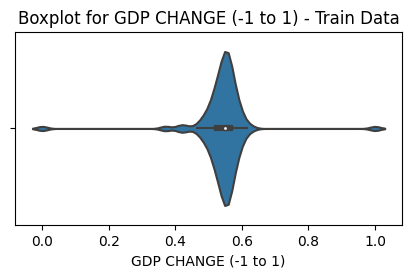

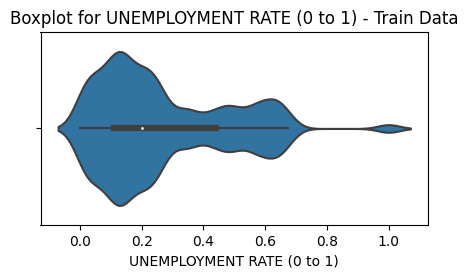

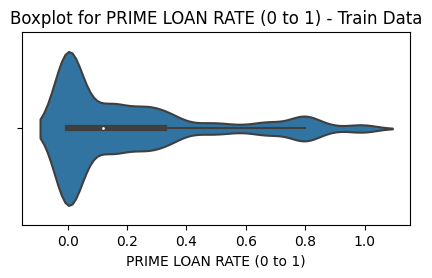

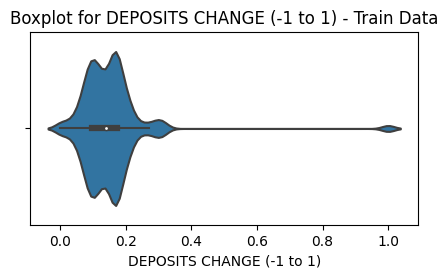

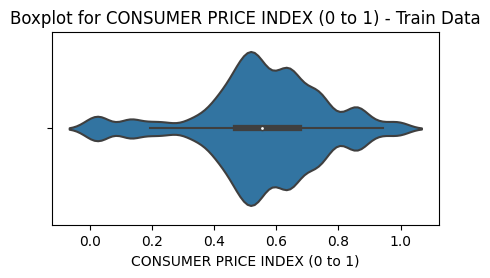

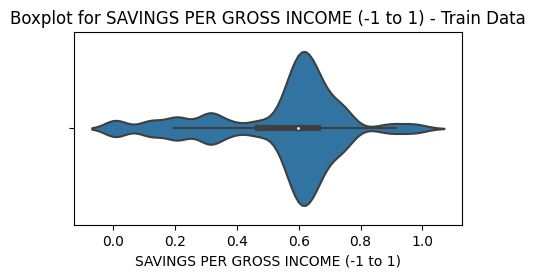

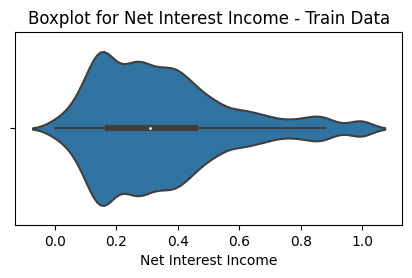

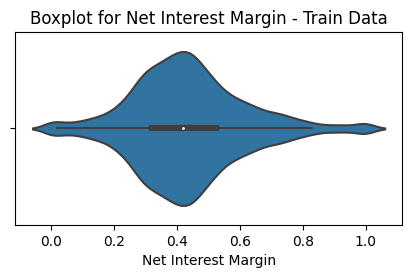

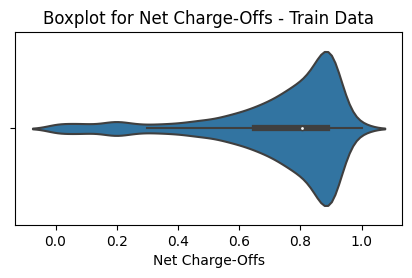

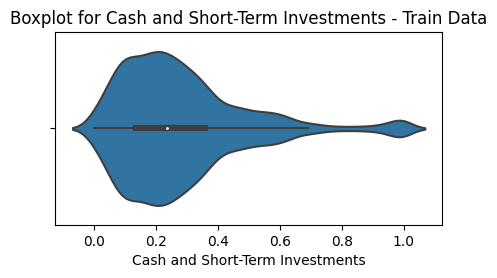

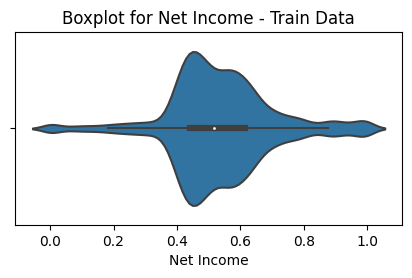

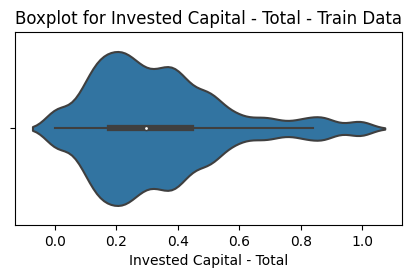

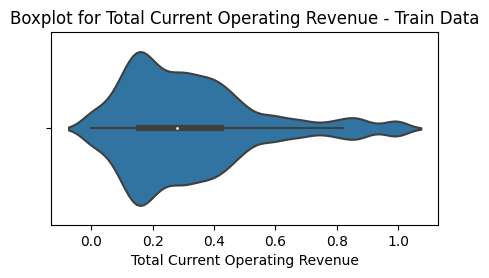

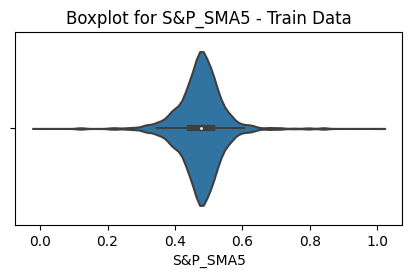

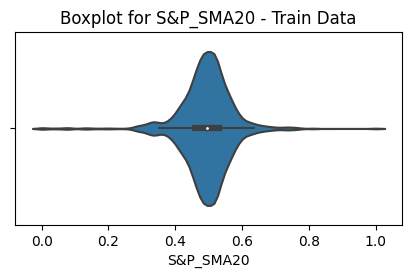

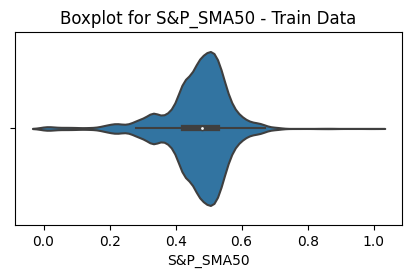

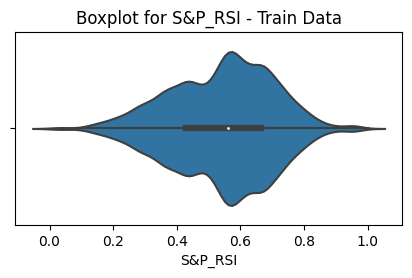

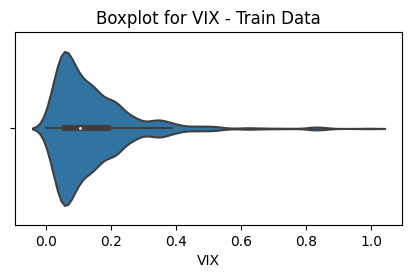

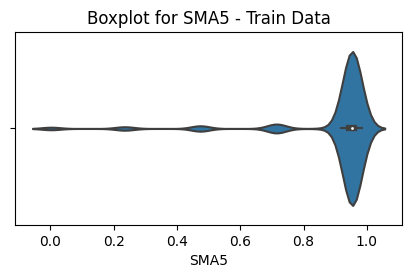

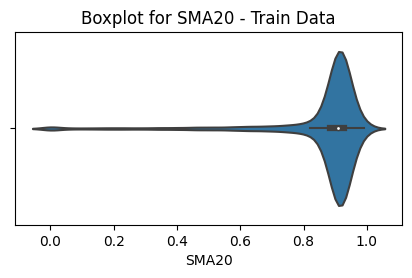

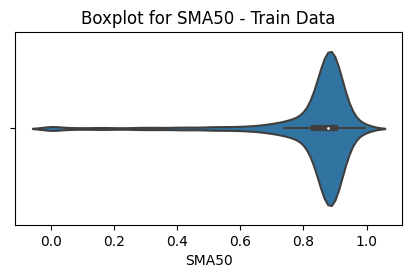

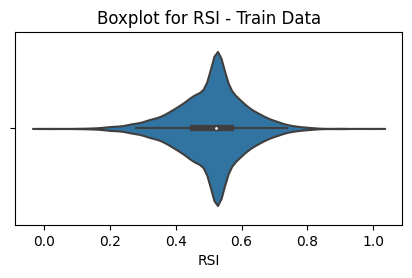

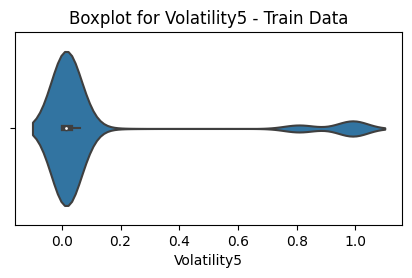

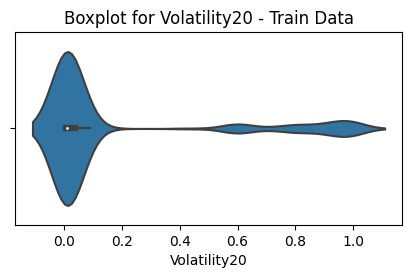

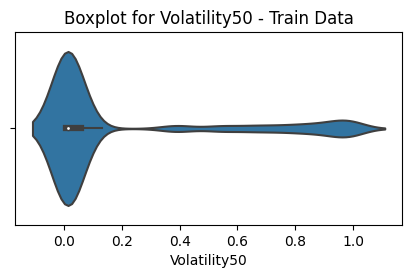

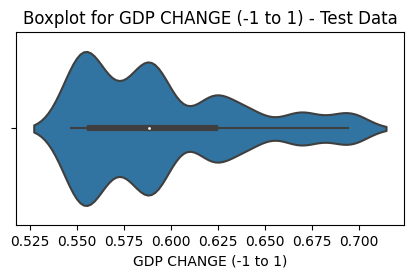

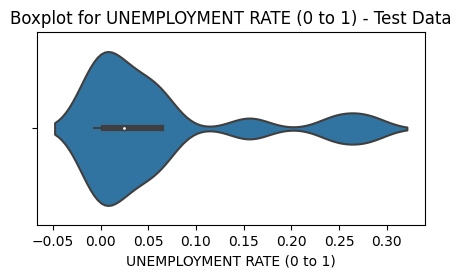

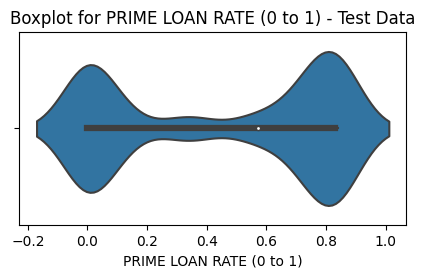

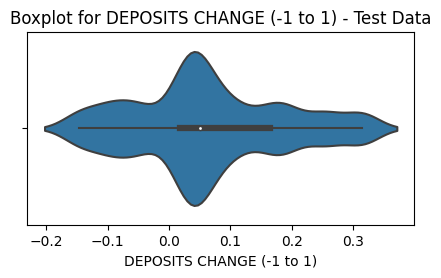

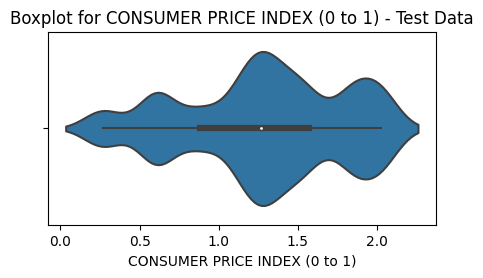

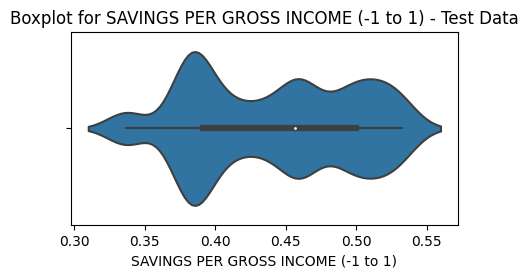

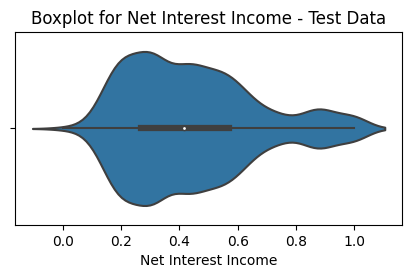

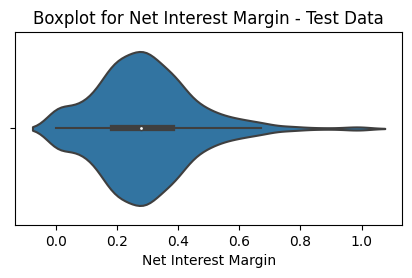

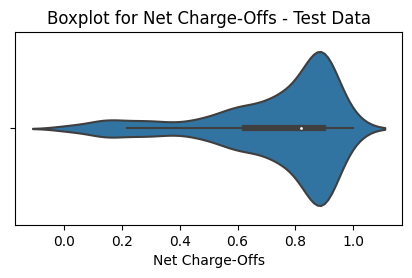

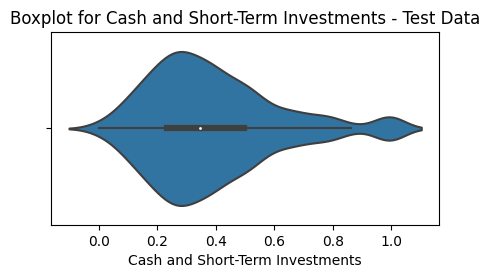

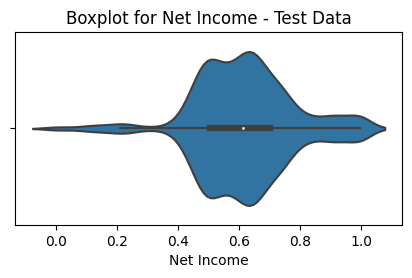

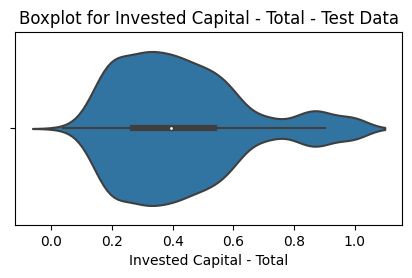

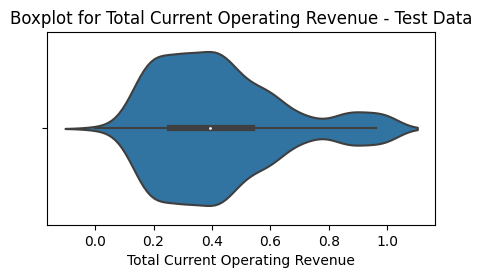

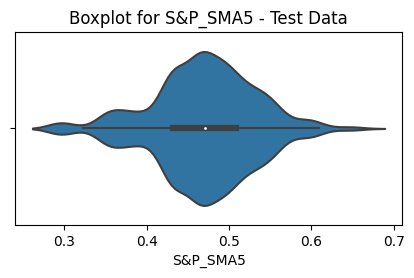

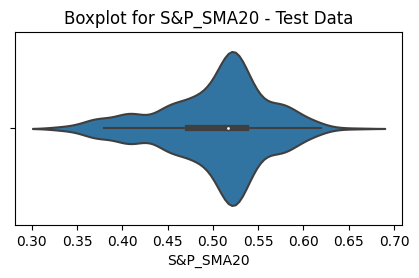

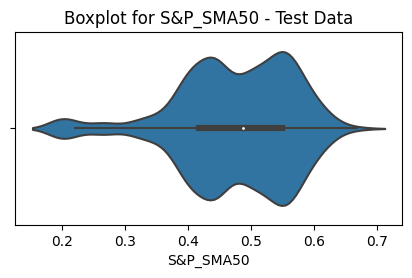

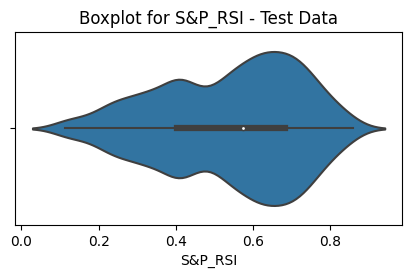

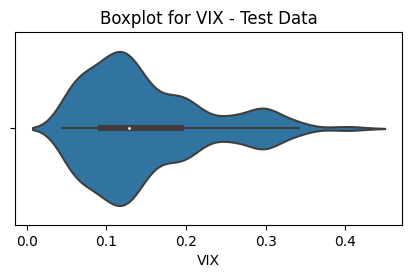

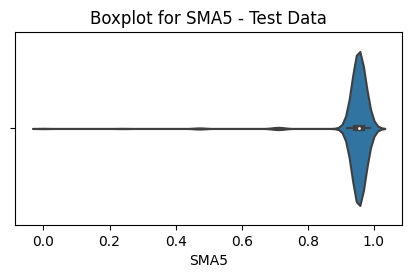

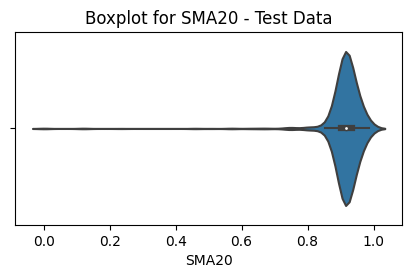

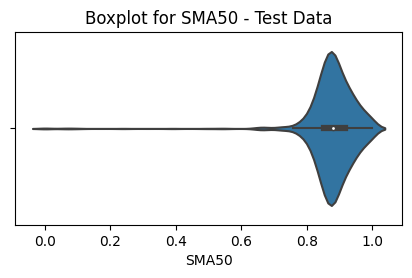

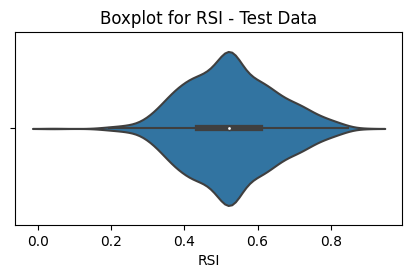

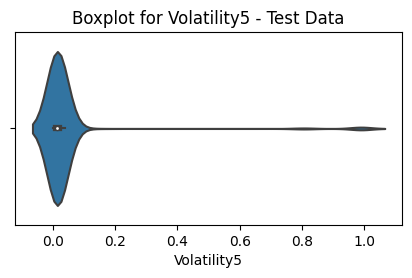

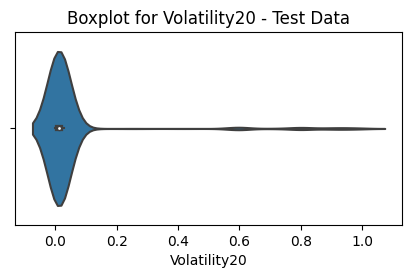

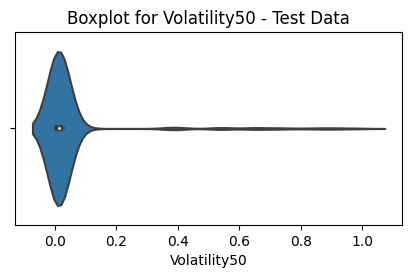

In [129]:
# plot wisker plot for train
for col in test_df.columns:
    if col not in {"tic", "datacqtr", "car5"}:
        plt.figure(figsize=(5, 2.5))
        sns.violinplot(x=train_df[col])
        plt.title(f"Boxplot for {col} - Train Data")
        plt.show()

# plot wisker plot for test
for col in test_df.columns:
    if col not in {"tic", "datacqtr", "car5"}:
        plt.figure(figsize=(5, 2.5))
        sns.violinplot(x=test_df[col])
        plt.title(f"Boxplot for {col} - Test Data")
        plt.show()

In [130]:
# Save the dataframes to csv files
train_df.to_csv("data/train_data_CAR5.csv", index=False)
test_df.to_csv("data/test_data_CAR5.csv", index=False)